# Module 2 - Image Segmentation and Region Finding

Before the popularization of neural networks, engineers and scientists spent lots of time developing routines to crop out regions of an images. This process of image segmentation and region finding is the first step to classifying images with margin and ensemble classifiers. Once the regions of interest are detected, features can be extracted to train, test, and apply a classifier. 

These techniques are useful for preprocessing data raw data and generating image metrics that preserve the original, physical scale of the data. It also provides a helpful baseline to compare against deep methods.

As with any python application, we first import the necessary libraries.

In [9]:
import numpy as np
import cv2
import skimage
from skimage import filters, morphology, measure, color
from scipy import ndimage
import sys
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

We have added a new libray to work with: skimage, short for Scikit-Image. This is another image processing toolbox that adds additonal functionality to OpenCV.

To start with, we will pull up a raw SPC image. This is what is directly captured on the sensor *in situ*.

/Users/enrique.montes/Documents/plankton-imaging/pogo_bioobs19_imaging/SHRINK-SPC-UW-1501200429144329-32334591114-000055.png


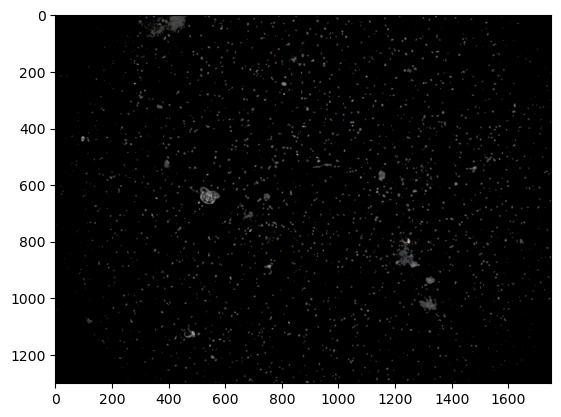

In [10]:
# get the file path of the image in the directory
ptf = glob.glob(os.path.join(os.getcwd(), 'SHRINK-SPC*'))
print(ptf[0])

# We will grab the first item in the list
img = cv2.imread(ptf[0])

# change to 

# now display it so we can see what we are working with
plt.imshow(img)

This does not look like much. Indeed, most of the full frame image is empty space. But take a closer look. Try taking a subimage from the full frame. Constrain the height between 550 and 700  and the width between 400 and 600.

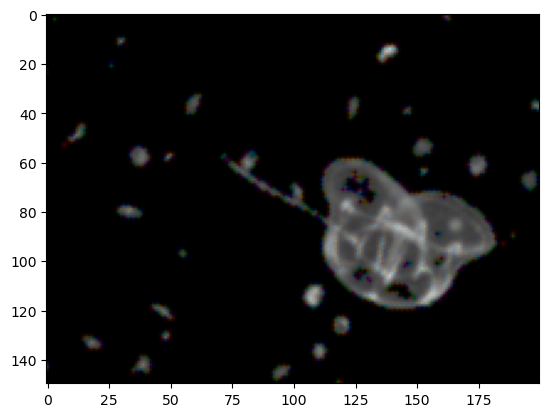

In [11]:
img_sub = img[550:700, 400:600]
plt.imshow(img_sub)

A human can go through and grab everything out of the frame in this manner, but it would be time consuming. Instead, we can use edge detection to find all the objects. 

## Region finding

There are many ways to find regions in an image. The specific method choosen for your data very much depends on the type of images and the background. We will just explore a few here.

It is important to note that none of these are completely fool proof. They all require some amount of human effort to emprically set parameters that dictate the behavior of the algorithm. It is important to test the fidelity of the code under many different conditions to ensure that it is behaving as expected.

### Thresholding

If the image background is uniform enough, setting a binary threshold to find pixels above a certain value might be sufficent. 

In [12]:
# first make a copy of the full image as a gray scale image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# now look at some of the image parameters. here we will use numpy to compute a few things
print("the max px: ", str(np.max(img_gray)))
print("the min px: ", str(np.min(img_gray)))
print("the mean px: ", str(np.mean(img_gray)))

the max px:  242
the min px:  0
the mean px:  2.6190230944854234


Given that most of the image is that minimum value or close to it, the mean might be an effective filter. 

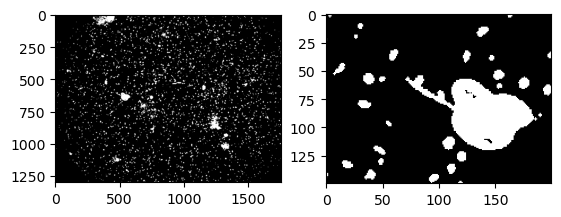

In [13]:
# use numpy to select the pixels and scale it
img_thresh = np.where(img_gray < np.mean(img_gray), 0., 1.0)

# this time plot the whole image and the subregion next to each other
fig, ax = plt.subplots(1, 2)  # subplots allow defining two sets of axes
ax[0].imshow(img_thresh, cmap='gray') # they can then be accessed numerically
ax[1].imshow(img_thresh[550:700, 400:600], cmap='gray')
plt.show()

The mean threholded image is kind of noisy. One option is to empirically pick several other threshold values and see how they work. Fortunately, there is an algorithmic approach. 

Otsu's method searches for a threshold in the image by examining it's intensity histogram.

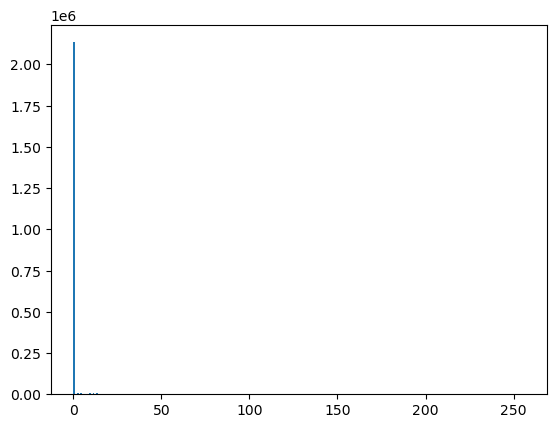

In [14]:
# Make an intensity histogram.
# ravel flattens the array, 256 is the number of bins, and [0, 256]
plt.hist(img_gray.ravel(), 256, [0, 256])
plt.show()

This displays the number of pixels in each bin. Clearly the most common bin is zero (ie black). This is akin to an intensity histogram you might use in Photoshop or iPhoto to mess with an images color. Zoom in to see more structure.

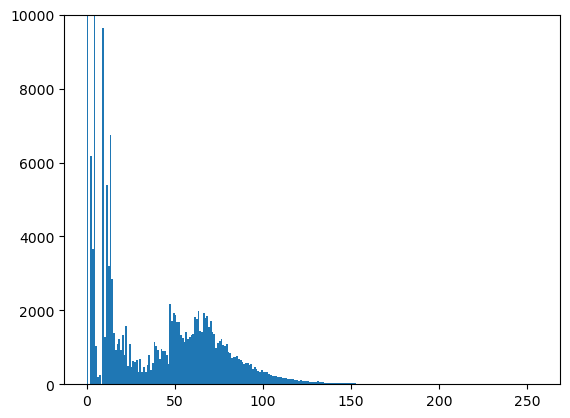

In [15]:
# zoom in on the intensity plot
plt.hist(img_gray.ravel(), 256, [0, 256])
plt.ylim([0, 10000])
plt.show()

Now we see that there are two peaks in the gray scale image. Otsu's method attempts to find a threshold that minimizes the variance of the pixels on either side of the boundary.

Otsu threshold:  34


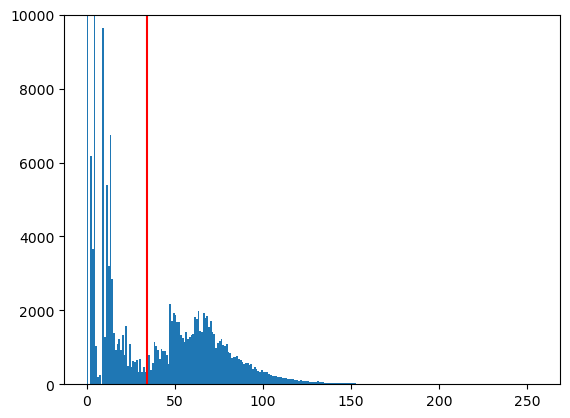

In [17]:
# use the skimage implimentation of Otsu's method
# thresh = filters.thresholding.threshold_otsu(img_gray)
from skimage.filters import threshold_otsu
thresh = threshold_otsu(img_gray)
print("Otsu threshold: ", str(thresh))

# now plot it on the intensity histogram 
import matplotlib.pyplot as plt
plt.hist(img_gray.ravel(), 256, [0, 256])
plt.ylim([0, 10000])
plt.axvline(x=thresh, color='r')
plt.show()

This might be more effective than using the mean. 

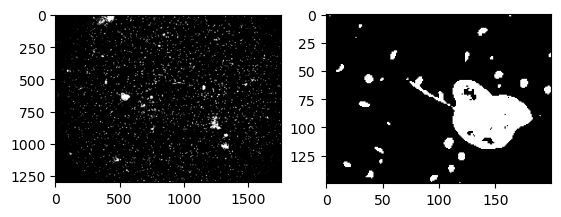

In [18]:
img_otsu = np.where(img_gray < thresh, 0., 1.0)

# plot the whole image and the subregion next to each other
fig, ax = plt.subplots(1, 2)  # subplots allow defining two sets of axes
ax[0].imshow(img_otsu, cmap='gray') # they can then be accessed numerically
ax[1].imshow(img_otsu[550:700, 400:600], cmap='gray')
plt.show()

While not perfect, Otsu's threshold helped element a lot of the small noise particles. 

Generally speaking, thresholding will discard a good amount of information. It works pretty well on SPC images because the foreground pixels are so distinct from the dark background. But you can see how difficult it would be to select a value that would grab all the stuff you are interested in a more complex image. 

### Filtering

Another good option for selecting regions in an image is *filtering*. An image filter is a sliding window that is dragged across an image to perform an operation in a neighboorhood around every pixel. A 3x3 median fitler, for example, computes the median value in a 3x3 window around the central pixel. In general, filters have odd numbered dimensions.

Akin to acoustics, filtering images can be described mathematically as a 2D convolution. That means the computer can cast the filtering operation as a multiplication in frequency space, rather than iteratively computing a value at every index. The details go beyond the scope of the tutorial.

There are many different operations that are done with filtering. In fact, convolutional neural networks make use of filters in the feature extraction phase. Here, we will use them to find edges.

#### Edge detection
Edges in images can be modeled as high frequency component of the image matrix. In other words, edges tend to be sharp discontinuities in pixel values. In the image we are working with, the pixels containing the plankton are bright and the background is dark. Where the pixels transition from light to dark will show up as an edge in the image.

We can exploit this to search for edges. First, try out a *Laplacian filter* -- a filter that computes the second derivative within the window. 

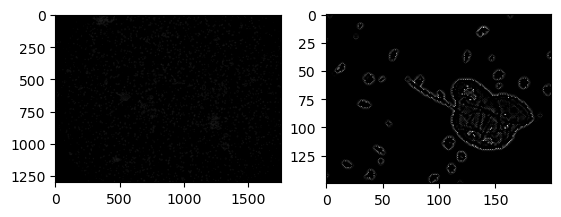

In [19]:
# Use a laplacian filter from OpenCV
img_laplace = cv2.Laplacian(img_gray, cv2.CV_16UC1, ksize=1)

# plot the whole image and the subregion next to each other
fig, ax = plt.subplots(1, 2)  # subplots allow defining two sets of axes
ax[0].imshow(img_laplace, cmap='gray')
ax[1].imshow(img_laplace[550:700, 400:600], cmap='gray')

The second arguement in the Laplacian command specifies the image depth, or data type of the output. We set it to uint16 to increase the percision of the computation. This is not always necessary, but it helps for a mostly empty image. *ksize* specificies the kernel size. ksize=1 gives us a kernal that look likes this:

$$\left[
\begin{matrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0 
\end{matrix}
 \right] $$
 
The 3x3 neighborhood around each pixel is multiplied by this matrix.The resulting values are all added together to get the output for the index at the center. 

This output looks better at a birds eye view. Take a closer look the gelatinous region. 

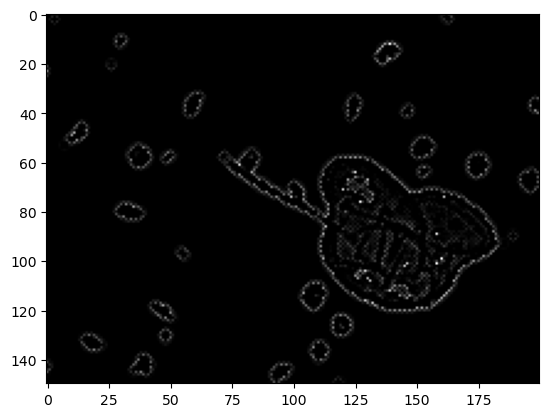

In [20]:
# select subregion and plot
plt.imshow(img_laplace[550:700, 400:600], cmap='gray')

We have found the outline of all the objects of the in the image. And we are starting to resolve some of the structure in the body of the organism itself.

#### Canny edge detector

The Canny edge detector is a multistage algorithm for edge detection written by John Canny in 1986. It works very well in many cases and is a common element of an image processors toolbox. There are 4 steps: 

1. Noise reduction -- generally done with a Gaussian smoothing filter. Basically, make the image a little blurry. 
2. Finding intensity gradients with a filter similar to the Laplacian.
3. Non-maximal suppresion forceses the edges to be thin. This stage outputs a binary images with the range [0 255].
4. Hysteresis thresholding determines which edges are real. This is done based on the minimum and maximum values the engineer gives the algorthm. A value above the max is sure to be an edge. A value below the minimum is sure *not* to be an edge. In between the max and the min, the algorithm checks to see if a line segement connects to a sure edge.

Setting the both the max and minimum values for the hysteresis thresholding high makes the edge detector more conservative. These thresholds need to be tinkered with empirically.

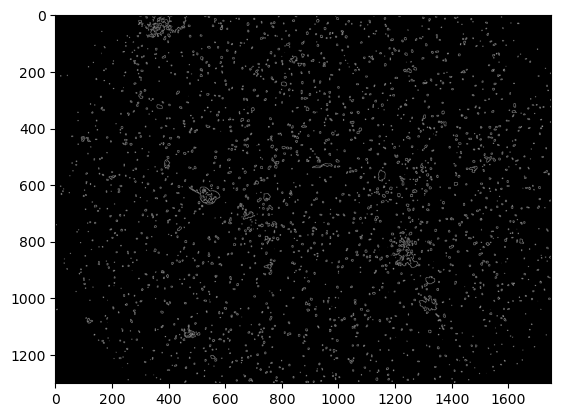

In [21]:
# run canny
img_canny = cv2.Canny(img_gray, 150, 225)

plt.imshow(img_canny, cmap='gray')

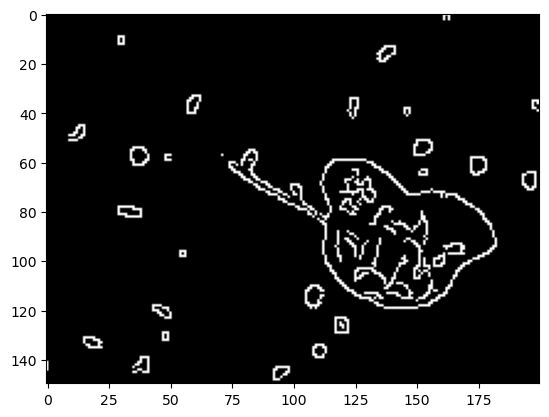

In [22]:
plt.imshow(img_canny[550:700, 400:600], cmap='gray')

Try changing the max and min values of the threshold to see what you get. 

### Extracting regions

Pulling out smaller regions from an image requries locating the desired objects. There are many algorithms implimented in both OpenCV and skimage to find region in an image. Here, we will illustrate the use of skimage's *label* routine. 

*label* uses connected component analysis to locate and label regions in an image. It checks each pixel to see how many neighboring pixels are in the foreground. Once it crawls all the pixels in a region, it gives the region a numeric label. The process repeats itself until all pixesl have been considered. 

To aid the process, it is good practice to use a morphological operators to connect edges and complete outlines. Morhpological opening and closing drag a *structuring element* -- a predefined shape used to probe foreground regions in a binary image.

Here we will use morphological closing. This routine will close small dark spots in otherwise complete objects. For this example, let's work with the Otsu thresholded image. We will use a square structuring element 5 pixel edges. 

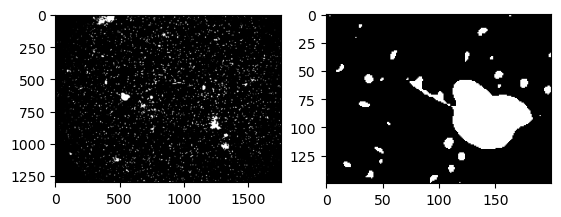

In [23]:
img_close = morphology.closing(img_otsu, morphology.square(5))

# plot the whole image and the subregion next to each other
fig, ax = plt.subplots(1, 2)  # subplots allow defining two sets of axes
ax[0].imshow(img_close, cmap='gray')
ax[1].imshow(img_close[550:700, 400:600], cmap='gray')

Now compare the original Otsu mask with the closed one.

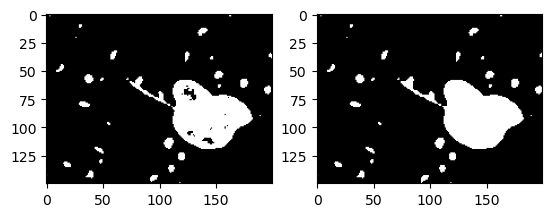

In [24]:
# plot the whole image and the subregion next to each other
fig, ax = plt.subplots(1, 2)  # subplots allow defining two sets of axes
ax[0].imshow(img_otsu[550:700, 400:600], cmap='gray')
ax[1].imshow(img_close[550:700, 400:600], cmap='gray')

With these complete masks we can now use skimage's region labeling. It will decide if a pixel belongs in a region by checking its connectivety using 8 neighbors. Consider the following grid:

$$\begin{matrix}
0 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0 
\end{matrix}$$

The pixel in the center is one, but all its neighbors are zero. Since it is not connected to anything else, it will be its own regions.

$$\begin{matrix}
1 & 0 & 0 \\
1 & 1 & 0 \\
1 & 0 & 0 
\end{matrix}$$

The pixel in the center of this grid, however, will be a part of the region defined by the neighbors to it's left. When using 8-neighbor connectivity, any value of 1 in the pixels around the center will register as a contiguous region. 

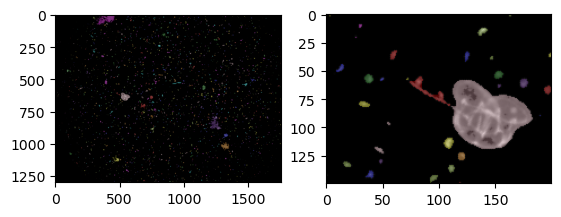

In [26]:
# New code added 
from skimage import measure, color
import matplotlib.pyplot as plt

# pass the label routine the closed image to register connected regions.
# label_img = morphology.label(img_close, neighbors=8, background=0) # this is part of the original code but was not working

# New code added 
label_img = measure.label(img_close, connectivity=2)  # Use `connectivity` instead of `neighbors`
lab_img_color = color.label2rgb(label_img, image=img_gray)

# plot the whole image and the subregion next to each other
fig, ax = plt.subplots(1, 2)  # subplots allow defining two sets of axes
ax[0].imshow(lab_img_color, cmap='gray')
ax[1].imshow(lab_img_color[550:700, 400:600], cmap='gray')

The colors correspond to different labeled regions. We can now feed this to labeled image to skimages *regionprops*, a routine that computes lots of information about a region based on the pixels inside it. For now, we will just use it compute the area -- the total number of pixels in the labeled region -- and the dimensions of a bounding boxes. 

In [27]:
# The last arguement is a list of features to pull out of each region
props = measure.regionprops(label_img, img_gray, ['Area', 'BoundingBox'])

# The length of this vector correspond to the number of regions found
print("The number of regions is: ", str(len(props)))

The number of regions is:  2521


That is a lot! regionprops grabbed all the little bits of detritus in the image. We can filter by area to only examine the biggest regions in the original image. 

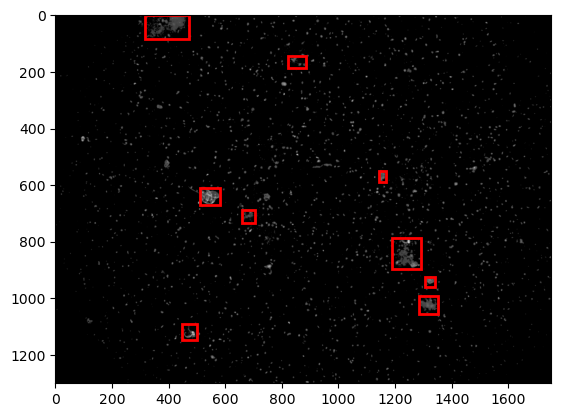

9  regions over  500  pixels


In [28]:
# first open up the original gray scale image as a background 
fig, ax = plt.subplots()
ax.imshow(img_gray, cmap = 'gray')

# initalize an empty vector to store all the bounding boxes
prop_out = []

# set the area threshold
area_thresh = 500

# iterate through the regions
for prop in props:
    
    # only select those with an area bigger than the threshold area
    if prop.area > area_thresh:
        
        # save a list of the big ones
        prop_out.append(prop.bbox)
        
        # Bounding box returns the coordinates of the miniumn and maximum row and column locations as:
        # [min_row, min_col, max_row, max_col]
        # We can use those values to generate a box in the image.
        rect = ptch.Rectangle((prop.bbox[1], prop.bbox[0]), prop.bbox[3] - prop.bbox[1], prop.bbox[2] - prop.bbox[0],
                          fill=False, edgecolor='red', linewidth=2)

        ax.add_patch(rect)
        
plt.show()

# state how many regions fit the critieria
print(str(len(prop_out)), " regions over ", str(area_thresh), " pixels")

We can now iterate through each of these and crop out the regions in side the bounding box.

In [29]:
# iterate through the regions and cut out the pixels from the original image. 
# first add some padding around the region to make sure the bounding box doesn't cut anything off. 
# here we will use half the width, effectively doubling the size of the boundary. 

# first initalize a dictionary to store the output. This will allow us to store arrays of different sizes. 
roi_out = dict()

# define an flag to count off the regions
flag = 0

for bbox in prop_out:
    
    # first, get the height and width of the box
    width = bbox[3] - bbox[1]
    height = bbox[2] - bbox[0]

    # now we will define the upper left corner of the box
    # make sure the values are integers for indexing with np.floor
    yy = bbox[1] - np.floor(width/2)
    xx = bbox[0] - np.floor(height/2)
    
    # force xx and yy to be integers
    xx = int(xx)
    yy = int(yy)
    
    # if either of the values are negative, force them to zero
    # this makes sure we get regions at the edge
    if xx < 0:
        xx = 0
    
    if yy < 0:
        yy = 0
        
    # now extract the region
    roi_temp = img_gray[xx:xx+2*width, yy:yy+2*height]
    
    # create a dictionary key with an f-string
    out_str = f"roi_{flag}"
    
    # save it out
    roi_out[out_str] = roi_temp
    
    # make sure to increase the value of the string
    flag += 1
    
print('Created ', str(flag), ' rois')

Created  9  rois


Now, loop through the dictonary to see what the results look like. 

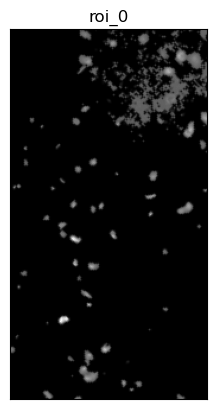

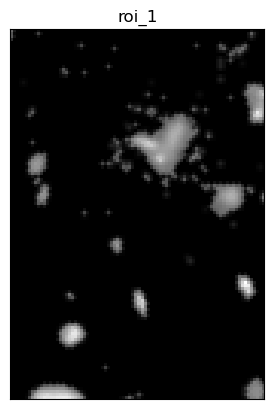

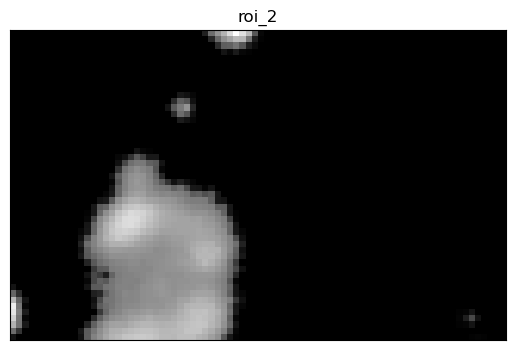

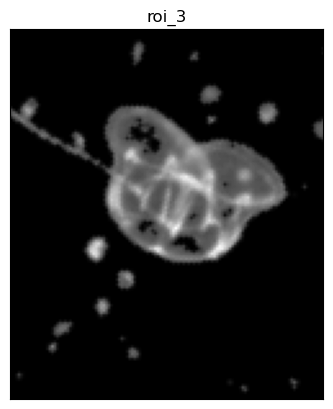

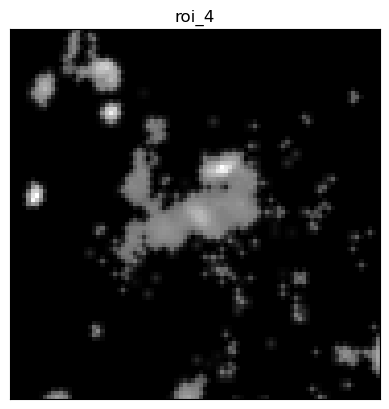

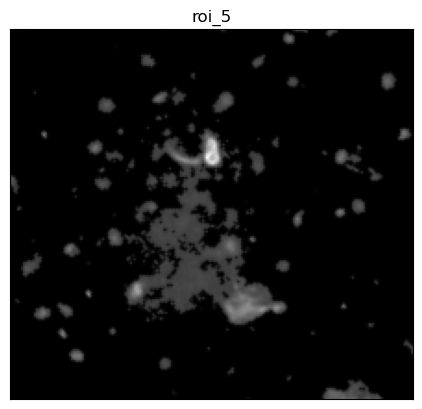

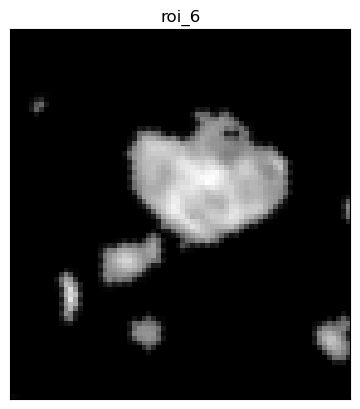

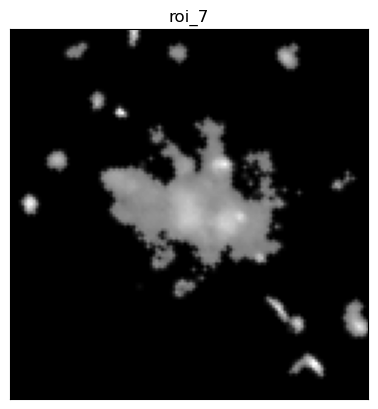

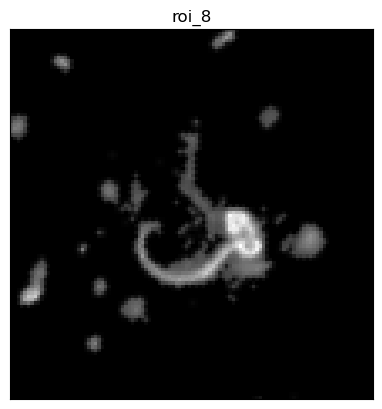

In [30]:
# loop over all the keys (roi names) in the dictonary
for kk in roi_out.keys():
    # create a new figure
    plt.figure()
    
    # turn off the axis numbers to make it a bit more readable
    plt.xticks([])
    plt.yticks([])
    
    # label each ROI 
    plt.title(kk)

    # show it in gray scale
    plt.imshow(roi_out[kk], cmap='gray')
    plt.show()

These ROIs can then be saved iteratively as their own files. This is what is done on the onboard computer of the SPC and in other plankton imaging instruments. This effectively cuts down on the amount of data stored. 

Other more optically dense types of image, such as benthic images, require more involved technqiues for image segmentation. Edge detection might be effective if the environment is sparse enough. Othewise, texture-based segmentation methods might be effective. And, or course, neural network based region finding might be the best bet. 